In [1]:
import pandas as pd
import numpy as np


%pylab inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

def numeric(self):
    '''Monkey-patches numeric features'''
    return self.select_dtypes(include=[np.number])
pd.DataFrame.numeric = numeric

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [5]:
# data = pd.DataFrame()

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
data = pd.read_csv('magic_stompy2018.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]]

meta_stats = ['won', 'life', 'opponents_life', 'deck', 'deck_size', 'computer', 'starting_lands', 'opponents_level']
cards = [i for i in data.columns if i not in meta_stats]

In [18]:
# Timestamp
now = len(data)

# How close I got to winning
data.set_value(now, 'won', 0)
data.set_value(now, 'life', 0)
data.set_value(now, 'opponents_life', 19)
data.set_value(now, 'deck_size', 60)
data.set_value(now, 'starting lands', 2)
data.set_value(now, 'land rating', 3)

# creatures
data.set_value(now, 'druid of the cowl', 0)
data.set_value(now, 'feral prowler', 0)
data.set_value(now, 'dryad greenseeker', 1)
data.set_value(now, 'greenbelt rampager', 0)
data.set_value(now, 'llanowar elves', 2)
data.set_value(now, 'mouth', 0)
data.set_value(now, 'steel life champion', 0)
data.set_value(now, 'thrashing brontodon', 0)
data.set_value(now, 'vine mare', 2)
data.set_value(now, 'walking ballista', 0)

# Artifacts
data.set_value(now, 'aethersphere harvester', 2)
data.set_value(now, 'lifecrafters bestiary', 0)
data.set_value(now, 'skysovereign', 1)
data.set_value(now, 'scrapheap scrounger', 0)

# Spells
data.set_value(now, 'blanchwood armor', 0)
data.set_value(now, 'blossoming defense', 2)
data.set_value(now, 'colossal majesty', 0)
data.set_value(now, 'natures way', 0)
data.set_value(now, 'plummet', 0)
data.set_value(now, 'rabid bite', 0)
data.set_value(now, 'song of freyalise', 0)
data.set_value(now, 'titanic growth', 0)
data.set_value(now, 'verdant rebirth', 0)

# Big boys
data.set_value(now, 'aggressive mamoth', 0)
data.set_value(now, 'ghalta', 1)
data.set_value(now, 'gigantosaurus', 1)
data.set_value(now, 'majestic myriarch', 0)
data.set_value(now, 'rhonas', 1)
data.set_value(now, 'scaled behemoth', 0)
data.set_value(now, 'verdurous gearhulk', 0)
data = data.fillna(0.)

data.to_csv('magic_stompy2018.csv')

In [16]:
# creatures = ['oketra', 'rhonas', 'serpopard', 'pacifist', 'baloth pup', 'mouth', 'croc',
# 'exemplar', 'defiant greatmaw', 'glorybound initiate', 'initiates companion',]

# removal = ['gideons reproach', 'reprisal', 'declare in stone', 'prepare']

# data['creatures_total'] = data[creatures].sum(axis=1)
# data['removal_total'] = data[removal].sum(axis=1)

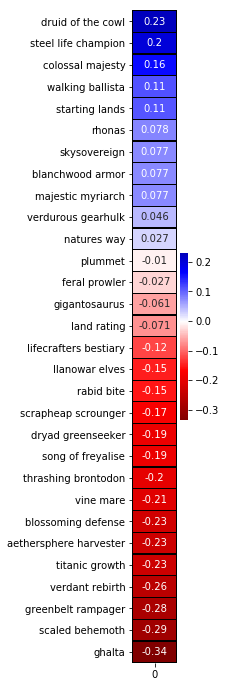

In [19]:
meta_stats = ['won', 'life', 'opponents_life', 'deck', 'deck_size', 'computer', 'starting_lands', 'opponents_level']
cards = [i for i in data.columns if i not in meta_stats]

winning_cards = data[cards].corrwith(data['won'])
winning_cards = pd.DataFrame(winning_cards).dropna().sort_values(0, ascending=False)
# winning_cards.drop(['opponents_life', 'won', 'life', 'deck'], inplace=True)
# pd.DataFrame(winning_cards).dropna().sort_values(0)

plt.figure(figsize=(1,12))

sns.heatmap(winning_cards,
           annot=True, cmap='seismic_r', linecolor='black',
           linewidths=.25, center=0)

In [20]:
from scipy import stats
sleep = []
for i in data.select_dtypes(include=[np.number]).drop(['life', 'opponents_life'], axis=1).columns:
    c = stats.pearsonr(data['won'], data[i])
    if c[1] < .1:
        if c[0] < .99:
            sleep.append([i, c[0], c[1]])


sleep = pd.DataFrame(sleep, columns=['card', 'corr', 'pvalue'])
sleep['absol'] = np.abs(sleep['corr'])

sleep.sort_values('absol', ascending=False).drop('absol', axis=1)

,card,corr,pvalue
1,ghalta,-0.335659,0.056174
0,scaled behemoth,-0.293176,0.097753


In [27]:
combinations = pd.DataFrame()

for i in cards:
    for j in cards:
        if i > j:
            combinations[i + ' + ' + j] = data[i] + data[j]

In [29]:
from scipy import stats
sleep = []
for i in combinations.columns:
    c = stats.pearsonr(data['won'], combinations[i])
    if c[1] < .1:
        if c[0] < .99:
            sleep.append([i, c[0], c[1]])


sleep = pd.DataFrame(sleep, columns=['card', 'corr', 'pvalue'])
sleep['absol'] = np.abs(sleep['corr'])

sleep.sort_values('absol', ascending=False).drop('absol', axis=1)

C:\Users\Vince\Anaconda3\lib\site-packages\scipy\stats\stats.py:5240: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


,card,corr,pvalue
1,mouth + always watching,-0.400278,0.031427
10,exemplar + elemental bond,0.394711,0.034092
0,went first + exemplar,0.383345,0.040098
9,exemplar + croc,0.379507,0.042307
7,pacifist + exemplar,0.360273,0.054881
8,gideons reproach + exemplar,0.359385,0.055525
2,mouth + declare in stone,-0.357158,0.057168
5,reprisal + exemplar,0.350230,0.062523
4,prepare + exemplar,0.341523,0.069799
3,prepare + mouth,-0.333174,0.077374


In [ ]:
# Timestamp
now = len(data)

# How close I got to winning
data.set_value(now, 'won', )
data.set_value(now, 'life', )
data.set_value(now, 'opponents_life', )
data.set_value(now, 'deck_size', 60)
data.set_value(now, 'starting lands', )
data.set_value(now, 'land rating', )

# creatures
data.set_value(now, 'druid of the cowl', 0)
data.set_value(now, 'feral prowler', 0)
data.set_value(now, 'dryad greenseeker', 0)
data.set_value(now, 'greenbelt rampager', 0)
data.set_value(now, 'llanowar elves', 0)
data.set_value(now, 'mouth', 0)
data.set_value(now, 'steel life champion', 0)
data.set_value(now, 'thrashing brontodon', 0)
data.set_value(now, 'vine mare', 0)
data.set_value(now, 'walking ballista', 0)

# Artifacts
data.set_value(now, 'aethersphere harvester', 0)
data.set_value(now, 'lifecrafters bestiary', 0)
data.set_value(now, 'skysovereign', 0)
data.set_value(now, 'scrapheap scrounger', 0)

# Spells
data.set_value(now, 'blanchwood armor', 0)
data.set_value(now, 'blossoming defense', 0)
data.set_value(now, 'colossal majesty', 0)
data.set_value(now, 'natures way', 0)
data.set_value(now, 'plummet', 0)
data.set_value(now, 'rabid bite', 0)
data.set_value(now, 'song of freyalise', 0)
data.set_value(now, 'titanic growth', 0)
data.set_value(now, 'verdant rebirth', 0)

# Big boys
data.set_value(now, 'aggressive mamoth', 0)
data.set_value(now, 'ghalta', 0)
data.set_value(now, 'gigantosaurus', 0)
data.set_value(now, 'majestic myriarch', 0)
data.set_value(now, 'rhonas', 0)
data.set_value(now, 'scaled behemoth', 0)
data.set_value(now, 'verdurous gearhulk', 0)
data = data.fillna(0.)

data.to_csv('magic_stompy2018.csv')